## All imports

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set() # setting seaborn default for plotsfrom sklearn import svm, tree, neighbors, neural_network
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn import preprocessing 
from sklearn.preprocessing import OneHotEncoder 
from sklearn.compose import ColumnTransformer 
from sklearn import svm, tree, neighbors, neural_network
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold


### Loading the train and test files

In [11]:
 train = pd.read_csv("train.csv")
 test = pd.read_csv("test.csv")

## Exploratory Data Analysis

### Analyzing the train data

In [12]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [13]:
train.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [14]:
# describes the descriptive statistics of the object data
train.describe(include=['O'])

,Name,Sex,Ticket,Cabin,Embarked
count,891,891,891,204,889
unique,891,2,681,147,3
top,"Zabour, Miss. Thamine",male,347082,G6,S
freq,1,577,7,4,644


In [15]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


<AxesSubplot:>

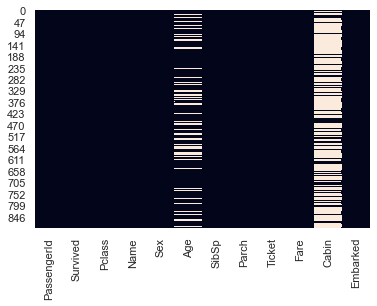

In [16]:
# Seaborn heatmap showing the null values. 
# This gives a nice visual of the entire train data.
sns.heatmap(train.isnull(), cbar=False)

# Clearly, Cabin column has a lot of null vals. and 
# while age col. also has null vals., the percentage does not seem that high.

In [17]:
# Here we will check the percentage of nan values present in each feature.
# While heatmap does a good job in giving the overview, it does not give the exact percentage
features_with_na=[features for features in train.columns if train[features].isnull().sum()>0]

for feature in features_with_na:
    print(feature, np.round(train[feature].isnull().mean(), 4)*100,  ' % missing values')

# Surprisingly, Embarked also has a small percentage of missing value, 
# which was not evident from the heatmap

Age 19.869999999999997  % missing values
Cabin 77.10000000000001  % missing values
Embarked 0.22  % missing values


D:\Program Files\Anaconda3\lib\site-packages\seaborn\axisgrid.py:316: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


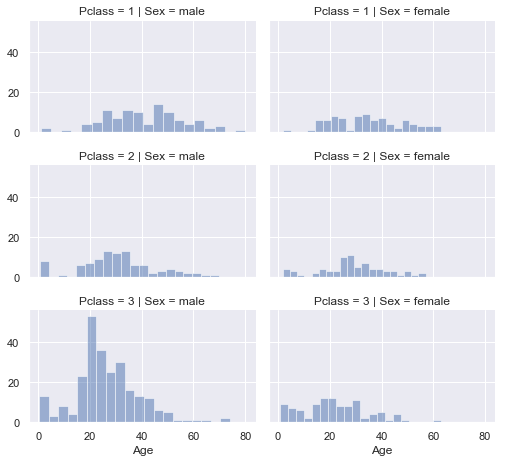

In [18]:
grid = sns.FacetGrid(train, row='Pclass', col='Sex', size=2.2, aspect=1.6)
grid.map(plt.hist, 'Age', alpha=.5, bins=20)
grid.add_legend()

## Dealing with Categorical values


### Dealing with the rare categorical features

#### # Rare categorical feature

In [19]:
categorical_features=[feature for feature in train.columns if train[feature].dtype=='O']

In [20]:
categorical_features

['Name', 'Sex', 'Ticket', 'Cabin', 'Embarked']

We'll create some features from the name category to provide us with better indication as to surviving members. This will be based on certain name titles seen and suprisingly name length which seems to have a strong impact. In addition, it was pointed out that breaking up the ticket number and cabin identifier would indicate differen placements on the ship which have a big impact on likelihood of escape.

In [21]:
def names(train, test):
    for i in [train, test]:
        i['Name_Len'] = i['Name'].apply(lambda x: len(x))
        i['Name_Title'] = i['Name'].apply(lambda x: x.split(',')[1]).apply(lambda x: x.split()[0])
        del i['Name']
    return train, test

def ticket_grouped(train, test):
    for i in [train, test]:
        i['Ticket_Lett'] = i['Ticket'].apply(lambda x: str(x)[0])
        i['Ticket_Lett'] = i['Ticket_Lett'].apply(lambda x: str(x))
        i['Ticket_Lett'] = np.where((i['Ticket_Lett']).isin(['1', '2', '3', 'S', 'P', 'C', 'A']), i['Ticket_Lett'],
                                   np.where((i['Ticket_Lett']).isin(['W', '4', '7', '6', 'L', '5', '8']),
                                            'Low_ticket', 'Other_ticket'))
        i['Ticket_Len'] = i['Ticket'].apply(lambda x: len(x))
        del i['Ticket']
    return train, test

def cabin(train, test):
    for i in [train, test]:
        i['Cabin_Letter'] = i['Cabin'].apply(lambda x: str(x)[0])
        del i['Cabin']
    return train, test

def cabin_num(train, test):
    for i in [train, test]:
        i['Cabin_num1'] = i['Cabin'].apply(lambda x: str(x).split(' ')[-1][1:])
        i['Cabin_num1'].replace('an', np.NaN, inplace = True)
        i['Cabin_num1'] = i['Cabin_num1'].apply(lambda x: int(x) if not pd.isnull(x) and x != '' else np.NaN)
        i['Cabin_num'] = pd.qcut(train['Cabin_num1'],3)
    train = pd.concat((train, pd.get_dummies(train['Cabin_num'], prefix = 'Cabin_num')), axis = 1)
    test = pd.concat((test, pd.get_dummies(test['Cabin_num'], prefix = 'Cabin_num')), axis = 1)
    del train['Cabin_num']
    del test['Cabin_num']
    del train['Cabin_num1']
    del test['Cabin_num1']
    return train, test
  
def dummies(train, test, columns = ['Ticket_Lett', 'Cabin_Letter', 'Name_Title']):
    for column in columns:
        train[column] = train[column].apply(lambda x: str(x))
        test[column] = test[column].apply(lambda x: str(x))
        good_cols = [column+'_'+i for i in train[column].unique() if i in test[column].unique()]
        train = pd.concat((train, pd.get_dummies(train[column], prefix = column)[good_cols]), axis = 1)
        test = pd.concat((test, pd.get_dummies(test[column], prefix = column)[good_cols]), axis = 1)
        del train[column]
        del test[column]
    return train, test

Gonna fill all null age values in.

In [22]:
def age_impute(train, test):
    for i in [train, test]:
        i['Age_Null_Flag'] = i['Age'].apply(lambda x: 1 if pd.isnull(x) else 0)
        data = train.groupby(['Name_Title', 'Pclass'])['Age']
        i['Age'] = data.transform(lambda x: x.fillna(x.mean()))
    return train, test

In [23]:
train,test = names(train,test)
train,test = ticket_grouped(train, test)
train,test = cabin_num(train, test)
train,test = cabin(train, test)
train,test = age_impute(train, test)
train,test = dummies(train, test)

In [24]:
train.head(20)

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Name_Len,...,Cabin_Letter_B,Cabin_Letter_F,Name_Title_Mr.,Name_Title_Mrs.,Name_Title_Miss.,Name_Title_Master.,Name_Title_Rev.,Name_Title_Dr.,Name_Title_Ms.,Name_Title_Col.
0,1,0,3,male,22.000000,1,0,7.2500,S,23,...,0,0,1,0,0,0,0,0,0,0
1,2,1,1,female,38.000000,1,0,71.2833,C,51,...,0,0,0,1,0,0,0,0,0,0
2,3,1,3,female,26.000000,0,0,7.9250,S,22,...,0,0,0,0,1,0,0,0,0,0
3,4,1,1,female,35.000000,1,0,53.1000,S,44,...,0,0,0,1,0,0,0,0,0,0
4,5,0,3,male,35.000000,0,0,8.0500,S,24,...,0,0,1,0,0,0,0,0,0,0
5,6,0,3,male,28.724891,0,0,8.4583,Q,16,...,0,0,1,0,0,0,0,0,0,0
6,7,0,1,male,54.000000,0,0,51.8625,S,23,...,0,0,1,0,0,0,0,0,0,0
7,8,0,3,male,2.000000,3,1,21.0750,S,30,...,0,0,0,0,0,1,0,0,0,0
8,9,1,3,female,27.000000,0,2,11.1333,S,49,...,0,0,0,1,0,0,0,0,0,0
9,10,1,2,female,14.000000,1,0,30.0708,C,35,...,0,0,0,1,0,0,0,0,0,0


In [25]:
train.head()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Name_Len,...,Cabin_Letter_B,Cabin_Letter_F,Name_Title_Mr.,Name_Title_Mrs.,Name_Title_Miss.,Name_Title_Master.,Name_Title_Rev.,Name_Title_Dr.,Name_Title_Ms.,Name_Title_Col.
0,1,0,3,male,22.0,1,0,7.2500,S,23,...,0,0,1,0,0,0,0,0,0,0
1,2,1,1,female,38.0,1,0,71.2833,C,51,...,0,0,0,1,0,0,0,0,0,0
2,3,1,3,female,26.0,0,0,7.9250,S,22,...,0,0,0,0,1,0,0,0,0,0
3,4,1,1,female,35.0,1,0,53.1000,S,44,...,0,0,0,1,0,0,0,0,0,0
4,5,0,3,male,35.0,0,0,8.0500,S,24,...,0,0,1,0,0,0,0,0,0,0


<AxesSubplot:>

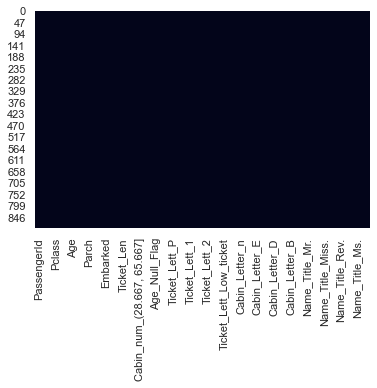

In [26]:
sns.heatmap(train.isnull(), cbar=False)


### Dealing with Sex feature

In [27]:
# label encoding
label_encoder = preprocessing.LabelEncoder() 

In [28]:
# Encode labels in column 'Sex'. 
train['Sex']= label_encoder.fit_transform(train['Sex']) 
  
train['Sex'].unique() 
# There is no need for one hot encoding

array([1, 0])

In [29]:
train.head()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Name_Len,...,Cabin_Letter_B,Cabin_Letter_F,Name_Title_Mr.,Name_Title_Mrs.,Name_Title_Miss.,Name_Title_Master.,Name_Title_Rev.,Name_Title_Dr.,Name_Title_Ms.,Name_Title_Col.
0,1,0,3,1,22.0,1,0,7.2500,S,23,...,0,0,1,0,0,0,0,0,0,0
1,2,1,1,0,38.0,1,0,71.2833,C,51,...,0,0,0,1,0,0,0,0,0,0
2,3,1,3,0,26.0,0,0,7.9250,S,22,...,0,0,0,0,1,0,0,0,0,0
3,4,1,1,0,35.0,1,0,53.1000,S,44,...,0,0,0,1,0,0,0,0,0,0
4,5,0,3,1,35.0,0,0,8.0500,S,24,...,0,0,1,0,0,0,0,0,0,0


### Dealing with the Age and Embarked

In [30]:
train_nan_map = {'Age': train['Age'].mean(),'Embarked': train['Embarked'].mode()[0]}
train.fillna(value=train_nan_map, inplace=True)
# [1,2,3,null,4] null --> 1+2+3+4/4 = 2.5

In [31]:
label_encoder = preprocessing.LabelEncoder() 
train['Embarked']= label_encoder.fit_transform(train['Embarked']) 
  
train['Embarked'].unique() 

array([2, 0, 1])

### Correlation matrix

<AxesSubplot:>

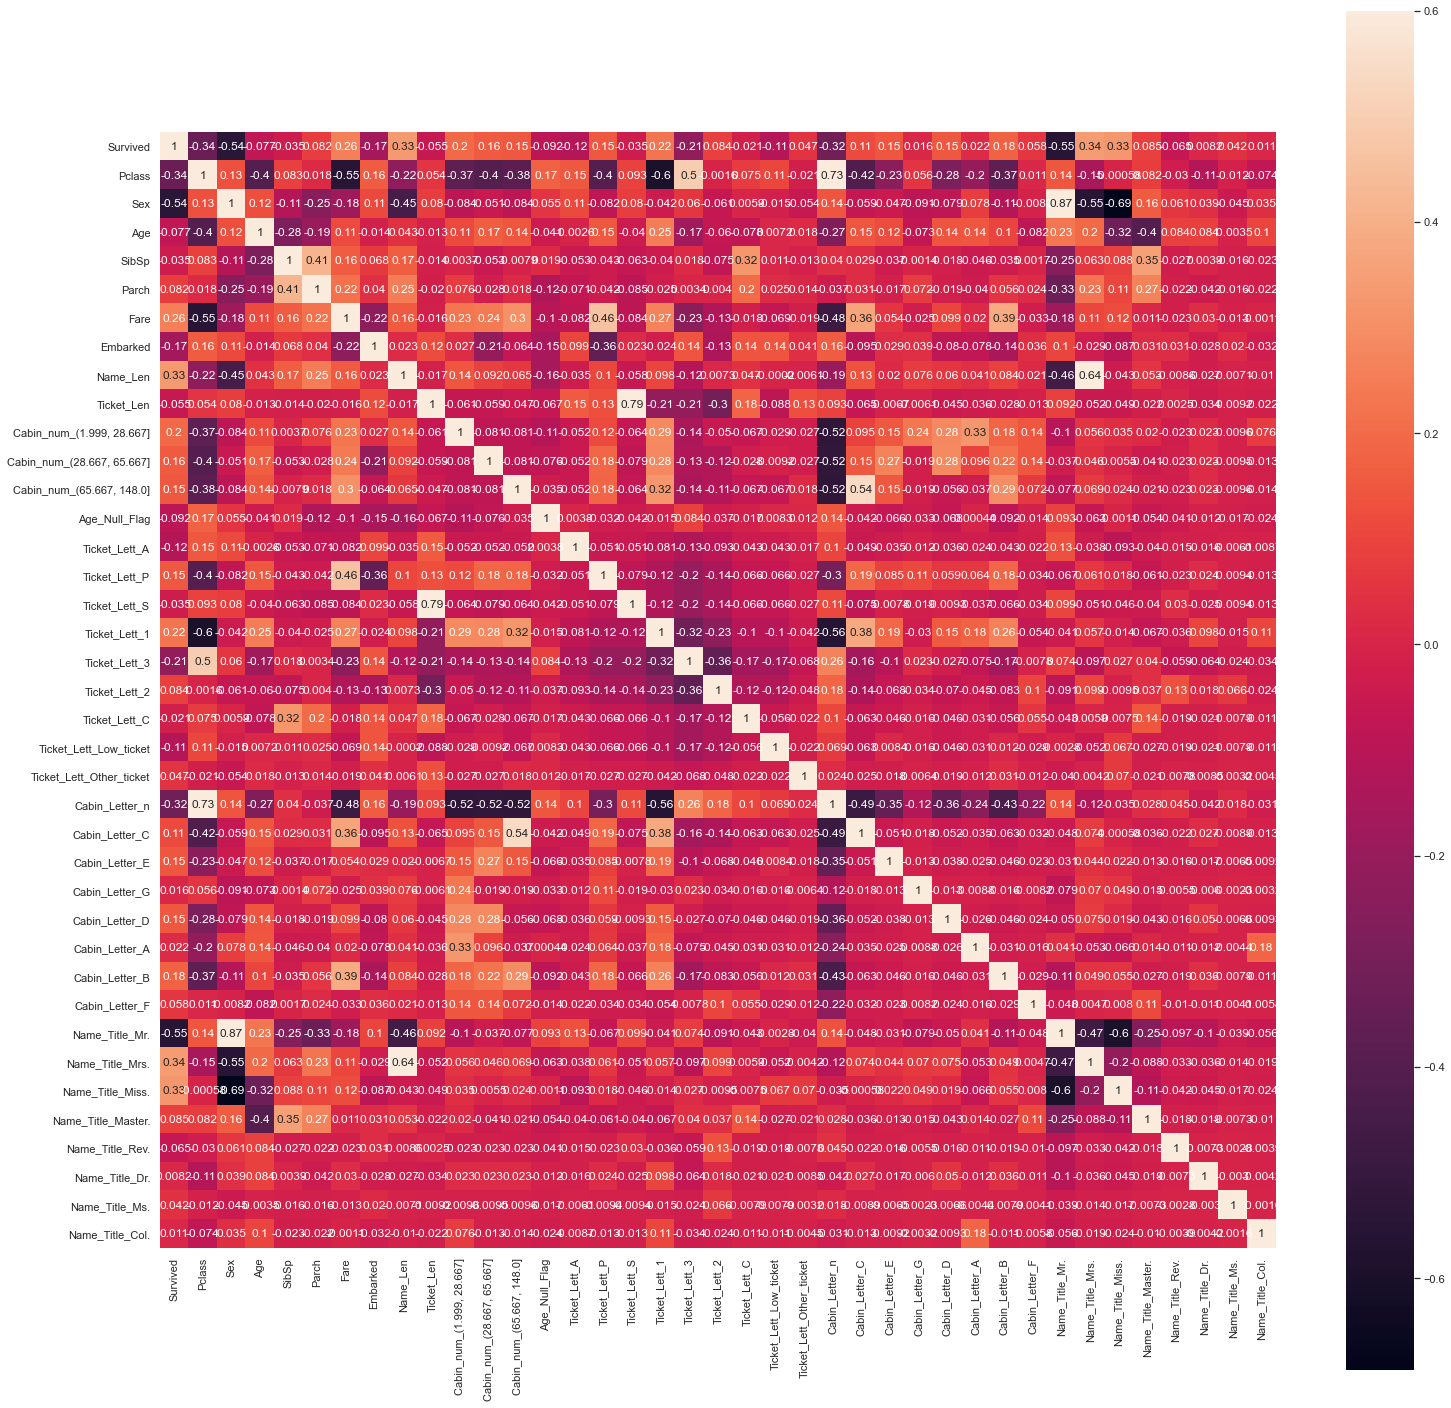

In [32]:
plt.figure(figsize=(25,25))
sns.heatmap(train.drop('PassengerId',axis=1).corr(), vmax=0.6, square=True, annot=True)

In [33]:
# Pclass and fair
# Rare categorical feature 

## Train Test Split

In [34]:
X_train = train.loc[:, train.columns != 'Survived']
y_train = train.loc[:, 'Survived']

X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.33, random_state=10)
accuracy = dict()
speed = dict()
FNR_FPR = dict()


In [35]:
print(X_train.head())
print(y_train.head())


     PassengerId  Pclass  Sex        Age  SibSp  Parch    Fare  Embarked  \
463          464       2    1  48.000000      0      0  13.000         2   
159          160       3    1   5.350833      8      2  69.550         2   
47            48       3    0  16.123188      0      0   7.750         1   
402          403       3    0  21.000000      1      0   9.825         2   
618          619       2    0   4.000000      2      1  39.000         2   

     Name_Len  Ticket_Len  ...  Cabin_Letter_B  Cabin_Letter_F  \
463        28           6  ...               0               0   
159        26           8  ...               0               0   
47         25           5  ...               0               0   
402        24           4  ...               0               0   
618        27           6  ...               0               1   

     Name_Title_Mr.  Name_Title_Mrs.  Name_Title_Miss.  Name_Title_Master.  \
463               1                0                 0              

In [36]:
X_train.columns

Index(['PassengerId', 'Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare',
       'Embarked', 'Name_Len', 'Ticket_Len', 'Cabin_num_(1.999, 28.667]',
       'Cabin_num_(28.667, 65.667]', 'Cabin_num_(65.667, 148.0]',
       'Age_Null_Flag', 'Ticket_Lett_A', 'Ticket_Lett_P', 'Ticket_Lett_S',
       'Ticket_Lett_1', 'Ticket_Lett_3', 'Ticket_Lett_2', 'Ticket_Lett_C',
       'Ticket_Lett_Low_ticket', 'Ticket_Lett_Other_ticket', 'Cabin_Letter_n',
       'Cabin_Letter_C', 'Cabin_Letter_E', 'Cabin_Letter_G', 'Cabin_Letter_D',
       'Cabin_Letter_A', 'Cabin_Letter_B', 'Cabin_Letter_F', 'Name_Title_Mr.',
       'Name_Title_Mrs.', 'Name_Title_Miss.', 'Name_Title_Master.',
       'Name_Title_Rev.', 'Name_Title_Dr.', 'Name_Title_Ms.',
       'Name_Title_Col.'],
      dtype='object')

In [37]:
X_train = X_train.rename({"Cabin_num_(1.999, 28.667]":"Cabin_num_(1.999, 28.667)", "Cabin_num_(28.667, 65.667]":"Cabin_num_(28.667, 65.667)", "Cabin_num_(65.667, 148.0]": "Cabin_num_(65.667, 148.0)"}, axis='columns') 
print(X_train.columns)

Index(['PassengerId', 'Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare',
       'Embarked', 'Name_Len', 'Ticket_Len', 'Cabin_num_(1.999, 28.667)',
       'Cabin_num_(28.667, 65.667)', 'Cabin_num_(65.667, 148.0)',
       'Age_Null_Flag', 'Ticket_Lett_A', 'Ticket_Lett_P', 'Ticket_Lett_S',
       'Ticket_Lett_1', 'Ticket_Lett_3', 'Ticket_Lett_2', 'Ticket_Lett_C',
       'Ticket_Lett_Low_ticket', 'Ticket_Lett_Other_ticket', 'Cabin_Letter_n',
       'Cabin_Letter_C', 'Cabin_Letter_E', 'Cabin_Letter_G', 'Cabin_Letter_D',
       'Cabin_Letter_A', 'Cabin_Letter_B', 'Cabin_Letter_F', 'Name_Title_Mr.',
       'Name_Title_Mrs.', 'Name_Title_Miss.', 'Name_Title_Master.',
       'Name_Title_Rev.', 'Name_Title_Dr.', 'Name_Title_Ms.',
       'Name_Title_Col.'],
      dtype='object')


In [80]:
NN_clf = neural_network.MLPClassifier(activation='tanh', solver='adam')
NN_clf.fit(X_train.values, y_train.values)
print(NN_clf.score(X_test.values, y_test.values))
y_pred = NN_clf.predict(X_test.values)
y_truth = y_test.values

tn, fp, fn, tp = confusion_matrix(y_truth, y_pred).ravel()
print("Confusion Matrix")
print(confusion_matrix(y_truth, y_pred, labels=[0, 1]))
print("")
print("True Negatives", tn)
print("False Positives", fp)
print("False Negatives", fn)
print("True Positives", tp)
FNR_FPR["Neural Network"] = (fn/(fn+tn), fp/(fp+tp))

0.8135593220338984
Confusion Matrix
[[154  37]
 [ 18  86]]

True Negatives 154
False Positives 37
False Negatives 18
True Positives 86


D:\Program Files\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


In [79]:
from sklearn import metrics
model = LogisticRegression(solver='lbfgs',max_iter=100000)
model.fit(X_train,y_train)
prediction3=model.predict(X_test)
print('The accuracy of the Logistic Regression is',metrics.accuracy_score(prediction3,y_test))
y_pred = model.predict(X_test.values)
y_truth = y_test.values

tn, fp, fn, tp = confusion_matrix(y_truth, y_pred).ravel()
print("Confusion Matrix")
print(confusion_matrix(y_truth, y_pred, labels=[0, 1]))
print("")
print("True Negatives", tn)
print("False Positives", fp)
print("False Negatives", fn)
print("True Positives", tp)
FNR_FPR["Logistic Regression"] = (fn/(fn+tn), fp/(fp+tp))

The accuracy of the Logistic Regression is 0.8203389830508474
Confusion Matrix
[[157  34]
 [ 19  85]]

True Negatives 157
False Positives 34
False Negatives 19
True Positives 85


In [60]:
svm_clf = svm.SVC(kernel='linear')
svm_clf.fit(X_train.values, y_train.values)
print(svm_clf.score(X_test.values, y_test.values))
y_pred = svm_clf.predict(X_test.values)
y_truth = y_test.values

tn, fp, fn, tp = confusion_matrix(y_truth, y_pred).ravel()
print("Confusion Matrix")
print(confusion_matrix(y_truth, y_pred, labels=[0, 1]))
print("")
print("True Negatives", tn)
print("False Positives", fp)
print("False Negatives", fn)
print("True Positives", tp)
FNR_FPR["SVM"] = (fn/(fn+tn), fp/(fp+tp))

0.8305084745762712
Confusion Matrix
[[161  30]
 [ 20  84]]

True Negatives 161
False Positives 30
False Negatives 20
True Positives 84


In [61]:
pip install catboost


Note: you may need to restart the kernel to use updated packages.


'D:\Program' is not recognized as an internal or external command,
operable program or batch file.


In [62]:
from catboost import CatBoostClassifier

model = CatBoostClassifier()

cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=5, random_state=22)
score = cross_val_score(model, X_train, y_train, scoring='accuracy', cv=cv, n_jobs=-1)

model = model.fit(X_train,y_train)
y_pred = model.predict(X_test.values)
y_truth = y_test.values
tn, fp, fn, tp = confusion_matrix(y_truth, y_pred).ravel()
print("Confusion Matrix")
print(confusion_matrix(y_truth, y_pred, labels=[0, 1]))
print("")
print("True Negatives", tn)
print("False Positives", fp)
print("False Negatives", fn)
print("True Positives", tp)
FNR_FPR["CatBoost"] = (fn/(fn+tn), fp/(fp+tp))

Learning rate set to 0.00826
0:	learn: 0.6887050	total: 59.2ms	remaining: 59.1s
1:	learn: 0.6840537	total: 60.8ms	remaining: 30.4s
2:	learn: 0.6795109	total: 62.4ms	remaining: 20.7s
3:	learn: 0.6754314	total: 63.7ms	remaining: 15.9s
4:	learn: 0.6708742	total: 65.2ms	remaining: 13s
5:	learn: 0.6681229	total: 66.2ms	remaining: 11s
6:	learn: 0.6639535	total: 67.5ms	remaining: 9.58s
7:	learn: 0.6591649	total: 69.1ms	remaining: 8.57s
8:	learn: 0.6551521	total: 70.6ms	remaining: 7.77s
9:	learn: 0.6515161	total: 71.8ms	remaining: 7.11s
10:	learn: 0.6467236	total: 73.3ms	remaining: 6.59s
11:	learn: 0.6427558	total: 74.7ms	remaining: 6.15s
12:	learn: 0.6391278	total: 75.9ms	remaining: 5.76s
13:	learn: 0.6348071	total: 77.4ms	remaining: 5.45s
14:	learn: 0.6311787	total: 78.9ms	remaining: 5.18s
15:	learn: 0.6270673	total: 80.3ms	remaining: 4.94s
16:	learn: 0.6226148	total: 81.9ms	remaining: 4.73s
17:	learn: 0.6191553	total: 83.4ms	remaining: 4.55s
18:	learn: 0.6155491	total: 84.8ms	remaining: 4.3

199:	learn: 0.3859521	total: 336ms	remaining: 1.34s
200:	learn: 0.3855446	total: 337ms	remaining: 1.34s
201:	learn: 0.3850529	total: 339ms	remaining: 1.34s
202:	learn: 0.3846477	total: 340ms	remaining: 1.33s
203:	learn: 0.3840615	total: 342ms	remaining: 1.33s
204:	learn: 0.3836326	total: 343ms	remaining: 1.33s
205:	learn: 0.3831397	total: 345ms	remaining: 1.33s
206:	learn: 0.3827232	total: 346ms	remaining: 1.33s
207:	learn: 0.3823509	total: 348ms	remaining: 1.32s
208:	learn: 0.3819534	total: 350ms	remaining: 1.32s
209:	learn: 0.3815908	total: 351ms	remaining: 1.32s
210:	learn: 0.3811717	total: 352ms	remaining: 1.32s
211:	learn: 0.3805423	total: 354ms	remaining: 1.31s
212:	learn: 0.3804382	total: 355ms	remaining: 1.31s
213:	learn: 0.3799244	total: 356ms	remaining: 1.31s
214:	learn: 0.3795283	total: 358ms	remaining: 1.31s
215:	learn: 0.3792892	total: 359ms	remaining: 1.3s
216:	learn: 0.3789415	total: 361ms	remaining: 1.3s
217:	learn: 0.3785218	total: 362ms	remaining: 1.3s
218:	learn: 0.3

444:	learn: 0.3165736	total: 666ms	remaining: 830ms
445:	learn: 0.3163824	total: 667ms	remaining: 828ms
446:	learn: 0.3162049	total: 668ms	remaining: 827ms
447:	learn: 0.3160609	total: 669ms	remaining: 825ms
448:	learn: 0.3158786	total: 671ms	remaining: 823ms
449:	learn: 0.3156141	total: 672ms	remaining: 821ms
450:	learn: 0.3154647	total: 673ms	remaining: 819ms
451:	learn: 0.3151278	total: 674ms	remaining: 818ms
452:	learn: 0.3147357	total: 676ms	remaining: 816ms
453:	learn: 0.3144854	total: 677ms	remaining: 815ms
454:	learn: 0.3143076	total: 679ms	remaining: 813ms
455:	learn: 0.3141184	total: 680ms	remaining: 811ms
456:	learn: 0.3138219	total: 681ms	remaining: 810ms
457:	learn: 0.3136885	total: 683ms	remaining: 808ms
458:	learn: 0.3133534	total: 684ms	remaining: 806ms
459:	learn: 0.3132390	total: 685ms	remaining: 804ms
460:	learn: 0.3129967	total: 686ms	remaining: 803ms
461:	learn: 0.3128937	total: 688ms	remaining: 801ms
462:	learn: 0.3127438	total: 689ms	remaining: 799ms
463:	learn: 

693:	learn: 0.2677846	total: 995ms	remaining: 439ms
694:	learn: 0.2676040	total: 996ms	remaining: 437ms
695:	learn: 0.2674556	total: 997ms	remaining: 436ms
696:	learn: 0.2671449	total: 998ms	remaining: 434ms
697:	learn: 0.2669884	total: 1000ms	remaining: 433ms
698:	learn: 0.2668602	total: 1s	remaining: 431ms
699:	learn: 0.2665718	total: 1s	remaining: 430ms
700:	learn: 0.2665441	total: 1s	remaining: 428ms
701:	learn: 0.2662292	total: 1s	remaining: 427ms
702:	learn: 0.2660777	total: 1.01s	remaining: 425ms
703:	learn: 0.2659526	total: 1.01s	remaining: 424ms
704:	learn: 0.2656884	total: 1.01s	remaining: 422ms
705:	learn: 0.2651256	total: 1.01s	remaining: 421ms
706:	learn: 0.2649131	total: 1.01s	remaining: 419ms
707:	learn: 0.2648547	total: 1.01s	remaining: 418ms
708:	learn: 0.2646618	total: 1.01s	remaining: 416ms
709:	learn: 0.2645170	total: 1.01s	remaining: 415ms
710:	learn: 0.2644540	total: 1.02s	remaining: 413ms
711:	learn: 0.2642723	total: 1.02s	remaining: 412ms
712:	learn: 0.2639813	t

939:	learn: 0.2256446	total: 1.32s	remaining: 84.6ms
940:	learn: 0.2254130	total: 1.33s	remaining: 83.2ms
941:	learn: 0.2252971	total: 1.33s	remaining: 81.7ms
942:	learn: 0.2251261	total: 1.33s	remaining: 80.3ms
943:	learn: 0.2249462	total: 1.33s	remaining: 78.9ms
944:	learn: 0.2248194	total: 1.33s	remaining: 77.5ms
945:	learn: 0.2247765	total: 1.33s	remaining: 76.1ms
946:	learn: 0.2245852	total: 1.33s	remaining: 74.7ms
947:	learn: 0.2245360	total: 1.33s	remaining: 73.2ms
948:	learn: 0.2243585	total: 1.34s	remaining: 71.8ms
949:	learn: 0.2242603	total: 1.34s	remaining: 70.4ms
950:	learn: 0.2239939	total: 1.34s	remaining: 69ms
951:	learn: 0.2238252	total: 1.34s	remaining: 67.6ms
952:	learn: 0.2233473	total: 1.34s	remaining: 66.2ms
953:	learn: 0.2232121	total: 1.34s	remaining: 64.8ms
954:	learn: 0.2230280	total: 1.34s	remaining: 63.4ms
955:	learn: 0.2228775	total: 1.35s	remaining: 62ms
956:	learn: 0.2226798	total: 1.35s	remaining: 60.6ms
957:	learn: 0.2225766	total: 1.35s	remaining: 59.2

In [75]:
rf = RandomForestClassifier(n_estimators=20)
rf = rf.fit(X_train,y_train)
y_pred = rf.predict(X_test.values)
y_truth = y_test.values

tn, fp, fn, tp = confusion_matrix(y_truth, y_pred).ravel()
print("Confusion Matrix")
print(confusion_matrix(y_truth, y_pred, labels=[0, 1]))
print("")
print("True Negatives", tn)
print("False Positives", fp)
print("False Negatives", fn)
print("True Positives", tp)
FNR_FPR["Random Forest"] = (fn/(fn+tn), fp/(fp+tp))

Confusion Matrix
[[171  20]
 [ 30  74]]

True Negatives 171
False Positives 20
False Negatives 30
True Positives 74


In [76]:
knn_clf = neighbors.KNeighborsClassifier(n_neighbors=30)
knn_clf.fit(X_train.values, y_train.values)
print(knn_clf.score(X_test.values, y_test.values))
y_pred = knn_clf.predict(X_test.values)
y_truth = y_test.values
y_pred = knn_clf.predict(X_test.values)
y_truth = y_test.values

tn, fp, fn, tp = confusion_matrix(y_truth, y_pred).ravel()
print("Confusion Matrix")
print(confusion_matrix(y_truth, y_pred, labels=[0, 1]))
print("")
print("True Negatives", tn)
print("False Positives", fp)
print("False Negatives", fn)
print("True Positives", tp)
FNR_FPR["K Neighbors"] = (fn/(fn+tn), fp/(fp+tp))

0.6949152542372882
Confusion Matrix
[[186   5]
 [ 85  19]]

True Negatives 186
False Positives 5
False Negatives 85
True Positives 19


dict_values([(0.10465116279069768, 0.3008130081300813), (0.10795454545454546, 0.2857142857142857), (0.11049723756906077, 0.2631578947368421), (0.11702127659574468, 0.2336448598130841), (0.14925373134328357, 0.2127659574468085), (0.31365313653136534, 0.20833333333333334)])


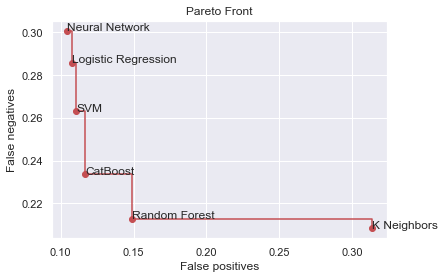

Area Under Curve: 1.1112909839763327


In [84]:
import matplotlib.pyplot as plt
import numpy as np

print(FNR_FPR.values())

x,y = zip(*(FNR_FPR.values()))
plt.scatter(x, y, color='r')
plt.plot(x, y, color='r', drawstyle='steps-post')
plt.xlabel("False positives")
plt.ylabel("False negatives")
plt.title("Pareto Front")

for key in FNR_FPR:
    val = FNR_FPR[key]
    plt.annotate(key, (val[0], val[1]))
    
x += (0,) + (1,)
y += (1,) + (0,)

plt.show()
print("Area Under Curve: %s" % (np.sum(np.abs(np.diff(x))*y[:-1])))